# COMS3007 - Machine Learning - Inference Coursework

## Setup

For all of the questions in this coursework we used the following Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread

Several functions were used to add noise and setup the input images:

In [2]:
def add_gaussian_noise(im,prop,varSigma):
    ########################################################################################
    # add_gaussian_noise - Created image with addition of Gaussina noise
    #   Inputs:
    #       im -> input image
    #       prop -> proportion of pixels to have noise added
    #       varSigma ->
    #   Outputs:
    #      im2 -> noisy image
    ########################################################################################
    N = int(np.round(np.prod(im.shape)*prop))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2 = np.float64(im2)
    im2[index] += e[index]

    return im2

def add_saltnpeppar_noise(im,prop):
    ########################################################################################
    # add_saltnpeppar_noise - Created image with addition of salt and pepper noise (flipped pixels)
    #   Inputs:
    #       im -> input image
    #       prop -> proportion of pixels to have noise added
    #   Outputs:
    #      im2 -> noisy image
    ########################################################################################
    N = int(np.round(np.prod(im.shape)*prop))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]

    return im2

def setup_image(img, prop, varSigma, level):
    ########################################################################################
    # setup_image - Creates different noisy images and sets noisy and latent images
    #   Inputs:
    #       img -> input image
    #       prop -> proportion of pixels to have noise added
    #       varSigma -> variance of gaussian noise
    #       level -> level of noise (gaussian, saltnpepper, both)
    #   Outputs:
    #      orgImg -> original grayscale image
    #      im2 -> gaussian noise image
    #      im3 -> salnpepper noise image
    #      im4 -> gaussian and slatnpepper noise image
    #      yImg -> noisy image
    #      xImg -> latent image
    ########################################################################################
    # read image and set values to +1 -1
    orgImg = imread(img)  # original image
    orgImg = np.asarray(orgImg, int)
    orgImg[orgImg < np.mean(orgImg)] = -1
    orgImg[orgImg >= np.mean(orgImg)] = 1

    # add noise to original image
    im2 = add_gaussian_noise(orgImg, prop, varSigma)  # gaussian noise
    im3 = add_saltnpeppar_noise(orgImg, prop)  # salt and pepper noise
    im4 = add_saltnpeppar_noise(im2, prop)  # gaussian + salt and pepper noise

    # set latent and noisy images
    if level == 1:  # gaussian noise only
        yImg = np.array(im2)  # noisy image
    elif level == 2:  # salt and pepper noise only
        yImg = np.array(im3)  # noisy image
    elif level == 3:  # both gaussian + salt and pepper noise
        yImg = np.array(im4)  # noisy image
    xImg = yImg  # latent image
    
    return orgImg, im2, im3, im4, yImg, xImg

Some other functions were used throughout the questions:

In [3]:
def neighbours(i,j,M,N,size=4):
    ########################################################################################
    # neighbours - Finds the neighbours of a node
    #   Inputs:
    #       i -> x position
    #       j -> y position
    #       M -> size of image in X
    #       N -> size of image in Y
    #       size -> 4 doesn't include diagonals, 8 does include diagonals
    #   Outputs:
    #       n -> array containing coordinates of neighbours
    ########################################################################################
    if size==4:
        if (i==0 and j==0):
             n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n

    if size==8:
        if (i==0 and j==0):
             n=[(0,1), (1,0), (1,1)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1), (1,N-2)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0), (M-2,1)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1), (M-2,N-2)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j), (1,j+1), (1,j-1)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1,j+1)]

        return n

def energy(noisyImg,latentImg,x,y,consts):
    ########################################################################################
    # energy - Calculates energy function
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       e -> energy of current state
    ########################################################################################
    e = consts[0]*latentImg[x,y] # h*sumXi
    e += -consts[2]*latentImg[x,y]*noisyImg[x,y] # -n*sumXiYi

    neighbour = neighbours(x, y, latentImg.shape[0], latentImg.shape[1], size=8)

    for ii in range(len(neighbour)):
        e += -consts[1]*latentImg[x,y]*latentImg[neighbour[ii]]

    return e

def convergence_rate(xImg,orgImg):
    ########################################################################################
    # convergence_rate - Calculates the percentage of pixels that are correct in the de-noised image
    #   Inputs:
    #       xImg -> latent image
    #       orgImg -> original image
    #   Outputs:
    #       convergence_rate -> percentage of pixels in xImg that are the same as in orgImg
    ########################################################################################
    convergence_rate = float(np.sum(xImg == orgImg)) / orgImg.size * 100.00
    return convergence_rate

def final_plot(orgImg, im2, im3, im4,xImg, level):
    ########################################################################################
    # final_plot - Plot original image, noisy image and de-noised image
    #   Inputs:
    #       orgImg -> original image
    #       im2 -> gaussian noise image
    #       im3 -> salt n pepper noise image
    #       im4 -> both gaussian and salt n pepper noise image
    #       xImg -> latent image
    #       level -> level of noise (guassian, saltnpepper, both)
    #   Outputs:
    #       plots original, noisy and de-noised image
    ########################################################################################
    if level == 1:
        noisy_im = im2
    if level == 2:
        noisy_im = im3
    if level == 3:
        noisy_im = im4
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(orgImg,cmap='gray')
    axarr[0].set_title('Original Image')
    axarr[1].imshow(noisy_im,cmap='gray')
    axarr[1].set_title('Noisy Image')
    axarr[2].imshow(xImg,cmap='gray')
    axarr[2].set_title('De-noised Image')
    # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
   # plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
   # plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
    plt.show()

## Question 1 - Iterative Conditional Models (ICM)

The functions to implement ICM are as follows:

In [4]:
def totalEnergy(noisyImg,latentImg,consts):
    ########################################################################################
    # totalEnergy - Calculates total energy for whole image
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       totalE -> total energy of image in current state
    ########################################################################################
    totalE = 0

    for i in range(latentImg.shape[0]):
        for j in range(latentImg.shape[1]):
            totalE += energy(noisyImg,latentImg,i,j,consts)

    return totalE


def icm(noisyImg,latentImg,x,y,consts,totalE):
    ########################################################################################
    # icm - Calculates best value of pixel for current state using ICM algorithm
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #       totalE -> total energy of image in current state
    #   Outputs:
    #       latentImg -> latent image with preferred pixel value
    #       totalE -> total energy of image in current state
    ########################################################################################
    orgEnergy = energy(noisyImg,latentImg, x, y, consts)
    diffEnergy = totalE - orgEnergy

    testLatentImg1 = np.copy(latentImg)
    testLatentImg2 = np.copy(latentImg)

    testLatentImg1[x,y] = -1
    testLatentImg2[x,y] = 1

    tstEnergy1 = energy(noisyImg,testLatentImg1, x, y, consts)
    tstEnergy2 = energy(noisyImg, testLatentImg2, x, y, consts)

    if tstEnergy1 < tstEnergy2:
        latentImg = testLatentImg1
        totalE = diffEnergy + tstEnergy1
    elif tstEnergy2 < tstEnergy1:
        latentImg = testLatentImg2
        totalE = diffEnergy + tstEnergy2

    return latentImg, totalE

An image, the proportion of pixels to alter and the constants for the ICM algorithm have to be set each time. For example:

### Running ICM on a noisy image with 20% of pixel affected by small noise levels of both Gaussian and salt and pepper noise

Iteration:  1
Total energy:  -53485.8246882
Percent of pixels correct:  95.37 %
Iteration:  2
Total energy:  -53872.9982248
Percent of pixels correct:  96.11 %
Iteration:  3
Total energy:  -53996.6052182
Percent of pixels correct:  96.19 %
Iteration:  4
Total energy:  -54027.5251509
Percent of pixels correct:  96.15 %
Iteration:  5
Total energy:  -54067.0115245
Percent of pixels correct:  96.14 %
Iteration:  6
Total energy:  -54073.4115245
Percent of pixels correct:  96.12 %
Iteration:  7
Total energy:  -54079.179013
Percent of pixels correct:  96.1 %
Stopped as image converged


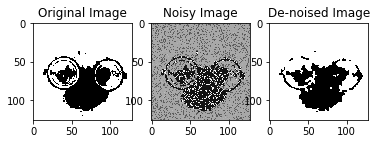

In [8]:
T = 20 # max number of iterations
# set proportion of pixels to alter
prop = 0.2
varSigma = 0.1
level = 3

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)
# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

# calculate total energy of noisy image
totalE = totalEnergy(yImg,xImg,consts)
currentE = totalE
    
for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg_old = xImg
            xImg, totalE = icm(yImg,xImg,x,y,consts,totalE)
            # print(currentE)    
    # break loop if energy hasn't been reduced since previous iteration
    if totalE == currentE:
        print("Stopped as image converged")
        break
    currentE = totalE
    print("Iteration: ", i+1)
    print("Total energy: ", totalE)
    print("Percent of pixels correct: ", round(convergence_rate(xImg,orgImg), 2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Running ICM on a noisy image with small Gaussian noise applied to all pixels:

Iteration:  1
Total energy:  -71054.3109475
Percent of pixels correct:  98.62 %
Iteration:  2
Total energy:  -71120.7307817
Percent of pixels correct:  98.38 %
Iteration:  3
Total energy:  -71153.0100017
Percent of pixels correct:  98.26 %
Iteration:  4
Total energy:  -71158.4635298
Percent of pixels correct:  98.22 %
Iteration:  5
Total energy:  -71167.7684648
Percent of pixels correct:  98.18 %
Iteration:  6
Total energy:  -71171.7046646
Percent of pixels correct:  98.16 %
Iteration:  7
Total energy:  -71175.4414938
Percent of pixels correct:  98.15 %
Iteration:  8
Total energy:  -71178.9770686
Percent of pixels correct:  98.13 %
Iteration:  9
Total energy:  -71180.2681446
Percent of pixels correct:  98.12 %
Iteration:  10
Total energy:  -71182.2079657
Percent of pixels correct:  98.12 %
Iteration:  11
Total energy:  -71184.6733631
Percent of pixels correct:  98.1 %
Iteration:  12
Total energy:  -71188.5010259
Percent of pixels correct:  98.08 %
Iteration:  13
Total energy:  -71191.4

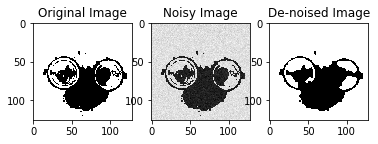

In [10]:
T = 20 # max number of iterations

# set proportion of pixels to alter
prop = 1.0
varSigma = 0.1
level = 1

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)
# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

# calculate total energy of noisy image
totalE = totalEnergy(yImg,xImg,consts)
currentE = totalE
    
for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
    
            xImg, totalE = icm(yImg,xImg,x,y,consts,totalE)
    
    # break loop if energy hasn't been reduced since previous iteration
    if totalE == currentE:
        print("Stopped as image converged")
        break
    currentE = totalE
    print("Iteration: ", i+1)
    print("Total energy: ", totalE)
    print("Percent of pixels correct: ", round(convergence_rate(xImg,orgImg), 2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Running ICM on a noisy image with larger Gaussian noise applied to all pixels:

Iteration:  1
Total energy:  -73394.4075629
Percent of pixels correct:  75.59 %
Iteration:  2
Total energy:  -77519.7404719
Percent of pixels correct:  76.15 %
Iteration:  3
Total energy:  -77888.3514952
Percent of pixels correct:  76.36 %
Iteration:  4
Total energy:  -77938.8276948
Percent of pixels correct:  76.4 %
Iteration:  5
Total energy:  -77948.8707149
Percent of pixels correct:  76.42 %
Iteration:  6
Total energy:  -77951.271949
Percent of pixels correct:  76.44 %
Iteration:  7
Total energy:  -77953.1298034
Percent of pixels correct:  76.44 %
Stopped as image converged


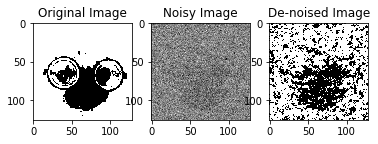

In [11]:
T = 20 # max number of iterations

# set proportion of pixels to alter
prop = 1.0
varSigma = 3.2
level = 1

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)
# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

# calculate total energy of noisy image
totalE = totalEnergy(yImg,xImg,consts)
currentE = totalE
  
for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
    
            xImg, totalE = icm(yImg,xImg,x,y,consts,totalE)
            # print(currentE)
    
    # break loop if energy hasn't been reduced since previous iteration
    if totalE == currentE:
        print("Stopped as image converged")
        break
    currentE = totalE
    print("Iteration: ", i+1)
    print("Total energy: ", totalE)
    print("Percent of pixels correct: ", round(convergence_rate(xImg,orgImg), 2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Running ICM on a noisy image with larger Gaussian noise applied to half of the pixels:

Iteration:  1
Total energy:  -69783.6798476
Percent of pixels correct:  87.08 %
Iteration:  2
Total energy:  -72275.2001331
Percent of pixels correct:  89.91 %
Iteration:  3
Total energy:  -72498.0780362
Percent of pixels correct:  90.42 %
Iteration:  4
Total energy:  -72536.9436898
Percent of pixels correct:  90.54 %
Iteration:  5
Total energy:  -72545.6173667
Percent of pixels correct:  90.58 %
Stopped as image converged


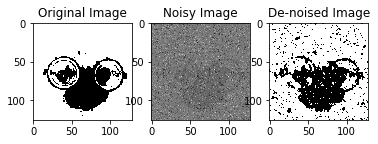

In [12]:
T = 20 # max number of iterations

# set proportion of pixels to alter
prop = 0.5
varSigma = 3.2
level = 1

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)
# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

# calculate total energy of noisy image
totalE = totalEnergy(yImg,xImg,consts)
currentE = totalE

    
for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
    
            xImg, totalE = icm(yImg,xImg,x,y,consts,totalE)
            # print(currentE)
    
    # break loop if energy hasn't been reduced since previous iteration
    if totalE == currentE:
        print("Stopped as image converged")
        break
    currentE = totalE
    print("Iteration: ", i+1)
    print("Total energy: ", totalE)
    print("Percent of pixels correct: ", round(convergence_rate(xImg,orgImg), 2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Running ICM on a noisy image with 20% of the pixels affected by salt and pepper noise:

Iteration:  1
Total energy:  -53566.9
Percent of pixels correct:  95.15 %
Iteration:  2
Total energy:  -54096.3
Percent of pixels correct:  96.05 %
Iteration:  3
Total energy:  -54199.5
Percent of pixels correct:  96.15 %
Iteration:  4
Total energy:  -54256.3
Percent of pixels correct:  96.16 %
Iteration:  5
Total energy:  -54258.7
Percent of pixels correct:  96.15 %
Iteration:  6
Total energy:  -54261.9
Percent of pixels correct:  96.14 %
Iteration:  7
Total energy:  -54263.1
Percent of pixels correct:  96.12 %
Stopped as image converged


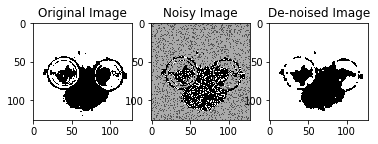

In [13]:
T = 20 # max number of iterations

# set proportion of pixels to alter
prop = 0.2
varSigma = 0.9
level = 2

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)
# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

# calculate total energy of noisy image
totalE = totalEnergy(yImg,xImg,consts)
currentE = totalE

    
for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
    
            xImg, totalE = icm(yImg,xImg,x,y,consts,totalE)
            # print(currentE)
    
    # break loop if energy hasn't been reduced since previous iteration
    if totalE == currentE:
        print("Stopped as image converged")
        break
    currentE = totalE
    print("Iteration: ", i+1)
    print("Total energy: ", totalE)
    print("Percent of pixels correct: ", round(convergence_rate(xImg,orgImg), 2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Running ICM on a noisy image with 50% of the pixels affected by salt and pepper noise:

Iteration:  1
Total energy:  -42734.6
Percent of pixels correct:  80.59 %
Iteration:  2
Total energy:  -43008.6
Percent of pixels correct:  80.58 %
Iteration:  3
Total energy:  -43044.6
Percent of pixels correct:  80.63 %
Iteration:  4
Total energy:  -43057.4
Percent of pixels correct:  80.62 %
Stopped as image converged


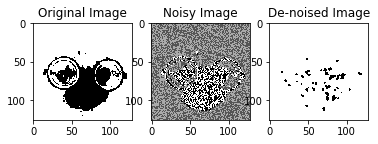

In [14]:
T = 20 # max number of iterations

# set proportion of pixels to alter
prop = 0.5
varSigma = 0.2
level = 2

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)
# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

# calculate total energy of noisy image
totalE = totalEnergy(yImg,xImg,consts)
currentE = totalE

    
for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
    
            xImg, totalE = icm(yImg,xImg,x,y,consts,totalE)
            # print(currentE)
    
    # break loop if energy hasn't been reduced since previous iteration
    if totalE == currentE:
        print("Stopped as image converged")
        break
    currentE = totalE
    print("Iteration: ", i+1)
    print("Total energy: ", totalE)
    print("Percent of pixels correct: ", round(convergence_rate(xImg,orgImg), 2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

## Questions 2-4 - Gibbs Sampling

The functions to implement Gibbs Sampling are as follows:

In [15]:
def gibbs(noisyImg,latentImg,x,y,consts):
    ########################################################################################
    # gibbs - Calculates best value of pixel for current state using gibbs sampling
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       latentImg -> latent image with preferred pixel value
    ########################################################################################
    testLatentImg1 = np.copy(latentImg)
    testLatentImg2 = np.copy(latentImg)

    testLatentImg1[x, y] = 1
    testLatentImg2[x, y] = -1

    tstEnergy1 = energy(noisyImg, testLatentImg1, x, y, consts)
    tstEnergy2 = energy(noisyImg, testLatentImg2, x, y, consts)

    px1 = np.exp(-tstEnergy1) / (np.exp(-tstEnergy2) + np.exp(-tstEnergy1)) # p(x_i=1 | x_\i,y_i)

    t = np.random.uniform(0,1)

    if px1 > t:
        latentImg = testLatentImg1
    else:
        latentImg = testLatentImg2

    return latentImg

## Question 2 - Gibbs Sampling with pixels picked sequentially

### Gibbs Sampling algorithm on a noisy image with 20% of pixel affected by Gaussian and salt and pepper noise

Iteration:  1
Convergence rate:  94.89 %
Iteration:  2
Convergence rate:  95.43 %
Iteration:  3
Convergence rate:  95.49 %
Iteration:  4
Convergence rate:  95.59 %
Iteration:  5
Convergence rate:  95.52 %
Iteration:  6
Convergence rate:  95.37 %
Iteration:  7
Convergence rate:  95.54 %
Iteration:  8
Convergence rate:  95.58 %
Iteration:  9
Convergence rate:  95.55 %
Iteration:  10
Convergence rate:  95.61 %


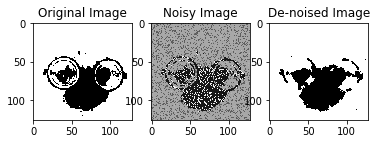

In [16]:
T = 10 # number of iterations

# set proportion of pixels to alter
prop = 0.2
varSigma = 0.1
level = 3

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")
    
final_plot(orgImg, im2, im3, im4, xImg, level)

### Gibbs Sampling algorithm on a noisy image with 50% of pixel affected by Gaussian and salt and pepper noise

Iteration:  1
Convergence rate:  81.17 %
Iteration:  2
Convergence rate:  81.13 %
Iteration:  3
Convergence rate:  80.83 %
Iteration:  4
Convergence rate:  80.61 %
Iteration:  5
Convergence rate:  80.41 %
Iteration:  6
Convergence rate:  80.43 %
Iteration:  7
Convergence rate:  80.52 %
Iteration:  8
Convergence rate:  80.47 %
Iteration:  9
Convergence rate:  80.44 %
Iteration:  10
Convergence rate:  80.3 %


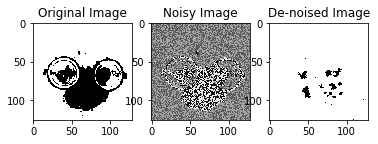

In [17]:
T = 10 # number of iterations

# set proportion of pixels to alter
prop = 0.5
varSigma = 0.1
level = 3

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Gibbs Sampling algorithm on a noisy image with 20% of pixel affected by Gaussian and salt and pepper noise - higher Gaussian noise

Iteration:  1
Convergence rate:  88.51 %
Iteration:  2
Convergence rate:  91.48 %
Iteration:  3
Convergence rate:  92.09 %
Iteration:  4
Convergence rate:  92.24 %
Iteration:  5
Convergence rate:  92.26 %
Iteration:  6
Convergence rate:  92.44 %
Iteration:  7
Convergence rate:  92.31 %
Iteration:  8
Convergence rate:  92.31 %
Iteration:  9
Convergence rate:  92.44 %
Iteration:  10
Convergence rate:  92.49 %


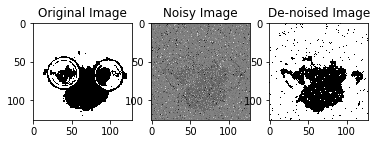

In [18]:
T = 10 # number of iterations

# set proportion of pixels to alter
prop = 0.2
varSigma = 3.2
level = 3

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Gibbs Sampling algorithm on a noisy image with 80% of pixel affected by larger Gaussian noise

Iteration:  1
Convergence rate:  79.5 %
Iteration:  2
Convergence rate:  80.88 %
Iteration:  3
Convergence rate:  81.51 %
Iteration:  4
Convergence rate:  81.99 %
Iteration:  5
Convergence rate:  81.97 %
Iteration:  6
Convergence rate:  82.17 %
Iteration:  7
Convergence rate:  81.75 %
Iteration:  8
Convergence rate:  81.8 %
Iteration:  9
Convergence rate:  81.8 %
Iteration:  10
Convergence rate:  81.83 %


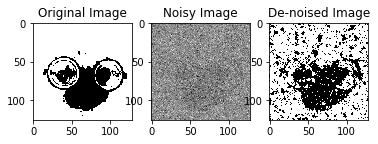

In [19]:
T = 10 # number of iterations

# set proportion of pixels to alter
prop = 0.8
varSigma = 3.2
level = 1

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Gibbs Sampling algorithm on a noisy image with 20% of pixel affected by salt and pepper noise

Iteration:  1
Convergence rate:  94.7 %
Iteration:  2
Convergence rate:  95.49 %
Iteration:  3
Convergence rate:  95.54 %
Iteration:  4
Convergence rate:  95.46 %
Iteration:  5
Convergence rate:  95.48 %
Iteration:  6
Convergence rate:  95.44 %
Iteration:  7
Convergence rate:  95.51 %
Iteration:  8
Convergence rate:  95.22 %
Iteration:  9
Convergence rate:  95.27 %
Iteration:  10
Convergence rate:  95.19 %


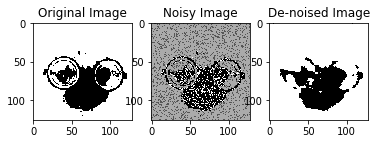

In [20]:
T = 10 # number of iterations

# set proportion of pixels to alter
prop = 0.2
varSigma = 3.2
level = 2

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

### Gibbs Sampling algorithm on a noisy image with 40% of pixel affected by salt and pepper noise

Iteration:  1
Convergence rate:  85.86 %
Iteration:  2
Convergence rate:  86.05 %
Iteration:  3
Convergence rate:  86.03 %
Iteration:  4
Convergence rate:  85.83 %
Iteration:  5
Convergence rate:  86.0 %
Iteration:  6
Convergence rate:  86.14 %
Iteration:  7
Convergence rate:  86.32 %
Iteration:  8
Convergence rate:  86.4 %
Iteration:  9
Convergence rate:  86.56 %
Iteration:  10
Convergence rate:  86.59 %


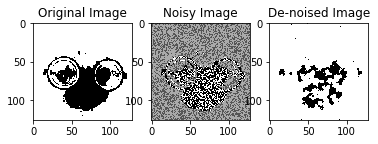

In [21]:
T = 10 # number of iterations

# set proportion of pixels to alter
prop = 0.4
varSigma = 0
level = 2

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")

final_plot(orgImg, im2, im3, im4, xImg, level)

## Question 3 - Gibbs Sampling using randomly ordered pixels

### Gibbs Sampling on a noisy image with Gaussian and salt and pepper noise applied to 20% of pixels

Iteration:  1
Convergence rate:  83.1 %
Iteration:  2
Convergence rate:  90.53 %
Iteration:  3
Convergence rate:  93.62 %
Iteration:  4
Convergence rate:  94.86 %
Iteration:  5
Convergence rate:  95.44 %
Iteration:  6
Convergence rate:  95.62 %
Iteration:  7
Convergence rate:  95.73 %
Iteration:  8
Convergence rate:  95.92 %
Iteration:  9
Convergence rate:  96.05 %
Iteration:  10
Convergence rate:  96.12 %


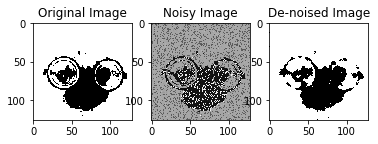

In [22]:
T = 10 # number of iterations

# set proportion of pixels to alter
prop = 0.2
varSigma = 0.1
level = 3

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

np.random.seed(42) # fix the random seed to get reproducible results
N = xImg.shape[0] * xImg.shape[1] # calculate number of pixels
for i in range(T):
    for a in range(1,N):

        x = np.random.randint(0,xImg.shape[0]) # pick random x
        y = np.random.randint(0,xImg.shape[1]) # pick random y
        xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling
        # print("x: ",x," y: ",y)

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")
    
final_plot(orgImg, im2, im3, im4, xImg, level)

## Question 4 - Gibbs Sampling - does the number of iterations always improve denoising?

In [ ]:
T = 20 # number of iterations

# set proportion of pixels to alter
prop = 0.2
varSigma = 0.1
level = 3

orgImg, im2, im3, im4, yImg, xImg = setup_image('pug-glasses.jpg',prop,varSigma,level)

# set energy function constants
n = 1 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg = gibbs(yImg, xImg, x, y, consts) # run gibbs sampling

    print("Iteration: ", (i+1))
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")
    #Printing each image to compare:
#     plotGibbs(xImg,i+1)
    
final_plot(orgImg, im2, im3, im4, xImg, level)

Iteration:  1
Convergence rate:  95.13 %
Iteration:  2
Convergence rate:  95.55 %
Iteration:  3
Convergence rate:  95.4 %
Iteration:  4
Convergence rate:  95.82 %
Iteration:  5
Convergence rate:  95.67 %
Iteration:  6
Convergence rate:  95.51 %
Iteration:  7
Convergence rate:  95.53 %


## Questions 6-7 - Variational Bayes

The functions to implement Variational Bayes are as follows:

In [5]:
def varBayes(noisyImg,latentImg,x,y,consts,mu):
    ########################################################################################
    # varBayes -> Calculates best value of pixel for current state using variational Bayes
    #               and updates variational parameter
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #       mu -> variational parameter
    #   Outputs:
    #       latentImg -> latent image with preferred pixel value
    #       mu -> variational parameter
    ########################################################################################
    # calculate variational parameter for current pixel
    m_i = 0
    neighbour = neighbours(x, y, latentImg.shape[0], latentImg.shape[1], size=8)
    for ii in range(len(neighbour)):
        neighbour1 = neighbour[ii]
        m_i = m_i + consts[1] * mu[neighbour1[0], neighbour1[1]]  
    a_i = m_i + (1 / 2) * ((consts[0] * 1 -consts[2] * 1 * noisyImg[x, y]) - (consts[0] * (-1) -consts[2] * -1 * noisyImg[x, y])) # where Li(xi) = h*sumXi - n*sumXiYi    
    mu_i = np.tanh(a_i)

    # update variational parameter matrix
    mu[x, y] = mu_i

    # calculate posterior for pixel i
    q_x = 1 / (1 + np.exp(-2 * a_i))
    
    # set pixel value in latent image (x) based on posterior
    if q_x < 0.5:
        latentImg[x, y] = 1
    else:
        latentImg[x, y] = -1

    return latentImg, mu

## Question 6 - Variational Bayes for Ising Model

Iteration:  1
Convergence rate:  94.35 %
Iteration:  2
Convergence rate:  96.62 %
Iteration:  3
Convergence rate:  96.84 %
Iteration:  4
Convergence rate:  96.85 %
Iteration:  5
Convergence rate:  96.83 %


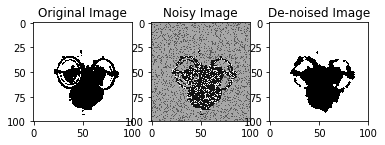

In [12]:
T = 5 # number of iterations

# set proportion of pixels to alter
prop = 0.2
varSigma = 0.1
level = 3

orgImg, im2, im3, im4, yImg, xImg = setup_image('pugGraySquare.png',prop,varSigma,level)

# set energy function constants
n = 1.5 # xiyi energy constant
beta = 0.5 # xixj energy constant
h = 0.3 # bias constant
consts = [h,beta,n]

mu = np.zeros([xImg.shape[0],xImg.shape[1]]) # variational distribution

for i in range(T):
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):
            xImg, mu = varBayes(yImg, xImg, x, y, consts,mu) # run variational bayes

    print("Iteration: ", (i+1))
    
    print("Convergence rate: ", round(convergence_rate(xImg,orgImg),2), "%")
    #Printing each image to compare:
#     plotGibbs(xImg,i+1)
    
final_plot(orgImg, im2, im3, im4, xImg, level)


## Question 7 - How does the result of the Variational Bayes method compare to the two previous approaches?

The variational Bayes method is much faster than both of the other methods and also appears to de-noise the image much better than they do.